In [1]:
from konlpy.tag import Okt
from konlpy import jvm
from soynlp.noun import LRNounExtractor_v2
from soynlp.word import WordExtractor
import pandas as pd
from pymongo import MongoClient

In [2]:
client = MongoClient('localhost', 27017)
db = client["news"]
collection = db["article"]

In [3]:
articles = pd.DataFrame(list(collection.find()))
df = articles.drop(axis=1,columns='_id')
df.shape

(65700, 22)

In [4]:
title = df['title']
title

0             中탐사선 3일경 달 뒷면 착륙… 우주경쟁서 美 처음 제친다
1         오늘부터 최저임금 8350원…근로자 500만명 인상 '역대 최대'
2           새해부터 최저임금 8350원, 주는 쪽도 받는 쪽도 불만인데…
3                 [리포트+] SNS 연하장 시대…이런 메시지는 공해
4           태양계 끝 날고 소행성 궤도 진입…새해 우주서 잇단 '신기록'
                         ...                  
65695    스마트폰 끼고 사는 요즘애들..노는 거냐고요? 일하고 공부도 하죠!
65696                 '여신강림'에 꽂혔다…중화권 홀린 네이버웹툰
65697       SKB 인터넷+케이블TV, 3년 내 위약금 없이 결합상품 해지
65698             내년 아이폰·중국폰 5G 협공…삼성폰은 '샌드위치'
65699             쓰레기통 뒤지는 북극곰…‘기후 위기’ 쇼크 10장면
Name: title, Length: 65700, dtype: object

In [5]:
import re
clean = re.sub('\W+',' ',title[845])

In [6]:
okt = Okt()
keywords=title.apply(lambda x: okt.pos(x, norm=True, stem=True))

In [7]:
print(keywords[0])
def keyword_filter(keywords):              
    filtered = []
    for keyword in keywords:
        if keyword[1] in ['Noun','Foreign']:
            filtered.append(re.sub('\W+|ㆍ',' ', keyword[0]).strip())
    return filtered
keywords = keywords.apply(lambda x: keyword_filter(x))

[('中', 'Foreign'), ('탐사선', 'Noun'), ('3일', 'Number'), ('경', 'Foreign'), ('달', 'Noun'), ('뒷', 'Modifier'), ('면', 'Noun'), ('착륙', 'Noun'), ('…', 'Punctuation'), ('우주경쟁', 'Noun'), ('서', 'Josa'), ('美', 'Foreign'), ('처음', 'Noun'), ('제', 'Noun'), ('치다', 'Verb')]


In [8]:
keywords.shape

(65700,)

In [9]:
keywords[5730]

['北', '명분', '美', '실리', '일단', '', '하노이', '핵', '담판', '다시', '조율', '모드']

In [10]:
df['title'][5730]

'北→명분ㆍ美→실리 일단 챙긴 ‘하노이 핵담판’…다시 숨가쁜 조율모드'

In [11]:
re.sub('\W+|ㆍ',' ', df['title'][5730])

'北 명분 美 실리 일단 챙긴 하노이 핵담판 다시 숨가쁜 조율모드'

In [12]:
df['keywords'] = keywords

In [13]:
df.head()

reaction_good  reaction_warm  reaction_sad  reaction_angry  reaction_next  \
0           83.0           10.0           7.0           288.0           10.0   
1         1153.0           31.0          30.0          6395.0           59.0   
2          451.0           51.0          71.0          8127.0          125.0   
3           76.0            8.0          11.0           111.0           32.0   
4          142.0           10.0           6.0            25.0           21.0   

   comment    male  female  age_10  age_20  ...  age_60  \
0    701.0   638.0    63.0    21.0    63.0  ...    42.0   
1   5687.0  4493.0  1194.0    57.0   569.0  ...   398.0   
2   8249.0  6434.0  1815.0   165.0  1402.0  ...   330.0   
3    242.0   169.0    73.0     2.0    41.0  ...    15.0   
4    150.0   126.0    24.0     8.0    16.0  ...    18.0   

                                  title  \
0      中탐사선 3일경 달 뒷면 착륙… 우주경쟁서 美 처음 제친다   
1  오늘부터 최저임금 8350원…근로자 500만명 인상 '역대 최대'   
2    새해부터 최저임금 8350원, 주는 쪽도 받는 쪽도 불만인데…   
3          [리포트+] SNS 연하장 시대…이런 메시지는 공해   
4    태양계 끝 날고 소행성 궤도 진입…새해 우주서 잇단 '신기록'   

                                                href  press section   views  \
0  https://news.naver.com/main/ranking/read.nhn?r...   동아일보     104  170309   
1  https://news.naver.com/main/ranking/read.nhn?r...    뉴스1     102  637054   
2  https://news.naver.com/main/ranking/read.nhn?r...   JTBC     101  758151   
3  https://news.naver.com/main/ranking/read.nhn?r...    SBS     103  308662   
4  https://news.naver.com/main/ranking/read.nhn?r...   연합뉴스     105   76153   

   year  month  day                               keywords  
0  2019      1    1  [中, 탐사선, 경, 달, 면, 착륙, 우주경쟁, 美, 처음, 제]  
1  2019      1    1         [오늘, 최저임금, 근로자, 명, 인상, 역대, 최대]  
2  2019      1    1                   [새해, 최저임금, 쪽, 쪽, 불만]  
3  2019      1    1                 [리포트, 연하, 시대, 메시지, 공해]  
4  2019      1    1  [태양계, 끝, 날, 소행성, 궤도, 진입, 새해, 우주, 신기록]  

[5 rows x 23 columns]

In [14]:
from gensim.models import Word2Vec
model = Word2Vec(df.dropna()['keywords'], size=100, window=5, min_count=10, workers=4, sg=0, sample = 1e-3)

In [15]:
model.wv.most_similar('최저임금')

[('평가', 0.9688760638237),
 ('이번', 0.9657006859779358),
 ('정책', 0.9553552865982056),
 ('격차', 0.9406116604804993),
 ('급락', 0.9403071403503418),
 ('당권', 0.9400162100791931),
 ('탈', 0.9396489262580872),
 ('동력', 0.9383324980735779),
 ('체제', 0.9340588450431824),
 ('예산', 0.9338966608047485)]

In [16]:
model.wv.most_similar('문재인')

[('문', 0.9314225912094116),
 ('기록관', 0.9313730597496033),
 ('文', 0.9282510876655579),
 ('하야', 0.9235952496528625),
 ('정치', 0.9203135371208191),
 ('비판', 0.9127235412597656),
 ('집무실', 0.9126483201980591),
 ('신년', 0.9099703431129456),
 ('보수', 0.9099017977714539),
 ('책임', 0.9094225168228149)]

In [17]:
model.wv.most_similar('정준영')

[('버닝썬', 0.9875277280807495),
 ('유정', 0.9778534173965454),
 ('구형', 0.9739513397216797),
 ('동영상', 0.9675332307815552),
 ('성관계', 0.9657536745071411),
 ('성매매', 0.9651164412498474),
 ('진술', 0.9639220237731934),
 ('무죄', 0.9629942774772644),
 ('몰카', 0.9621331691741943),
 ('피해자', 0.9612744450569153)]

In [18]:
model.wv.most_similar('김정은')

[('트럼프', 0.9577117562294006),
 ('북미', 0.9487130045890808),
 ('회담', 0.9465543031692505),
 ('북한', 0.9401034712791443),
 ('하노이', 0.93934166431427),
 ('北', 0.9388974905014038),
 ('볼턴', 0.9363126754760742),
 ('정상회담', 0.9322302937507629),
 ('비핵화', 0.9292067289352417),
 ('북', 0.9282594323158264)]

In [19]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

# model_name = '300features_40minwords_10text'
# model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model.wv[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])

7097
[-0.01097418 -0.3997806  -0.68530476 -0.07480921  0.6501804   0.1130065
 -0.4888744  -0.2298851  -0.16273096 -0.4630366 ]


In [20]:
temp = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
temp.shape

(100, 2)

In [21]:
temp.head()

x         y
中    1.842921 -0.531304
탐사선 -0.250490  4.857401
경    1.976446  5.793652
달   -0.285521  1.439878
면    0.737825  2.552805

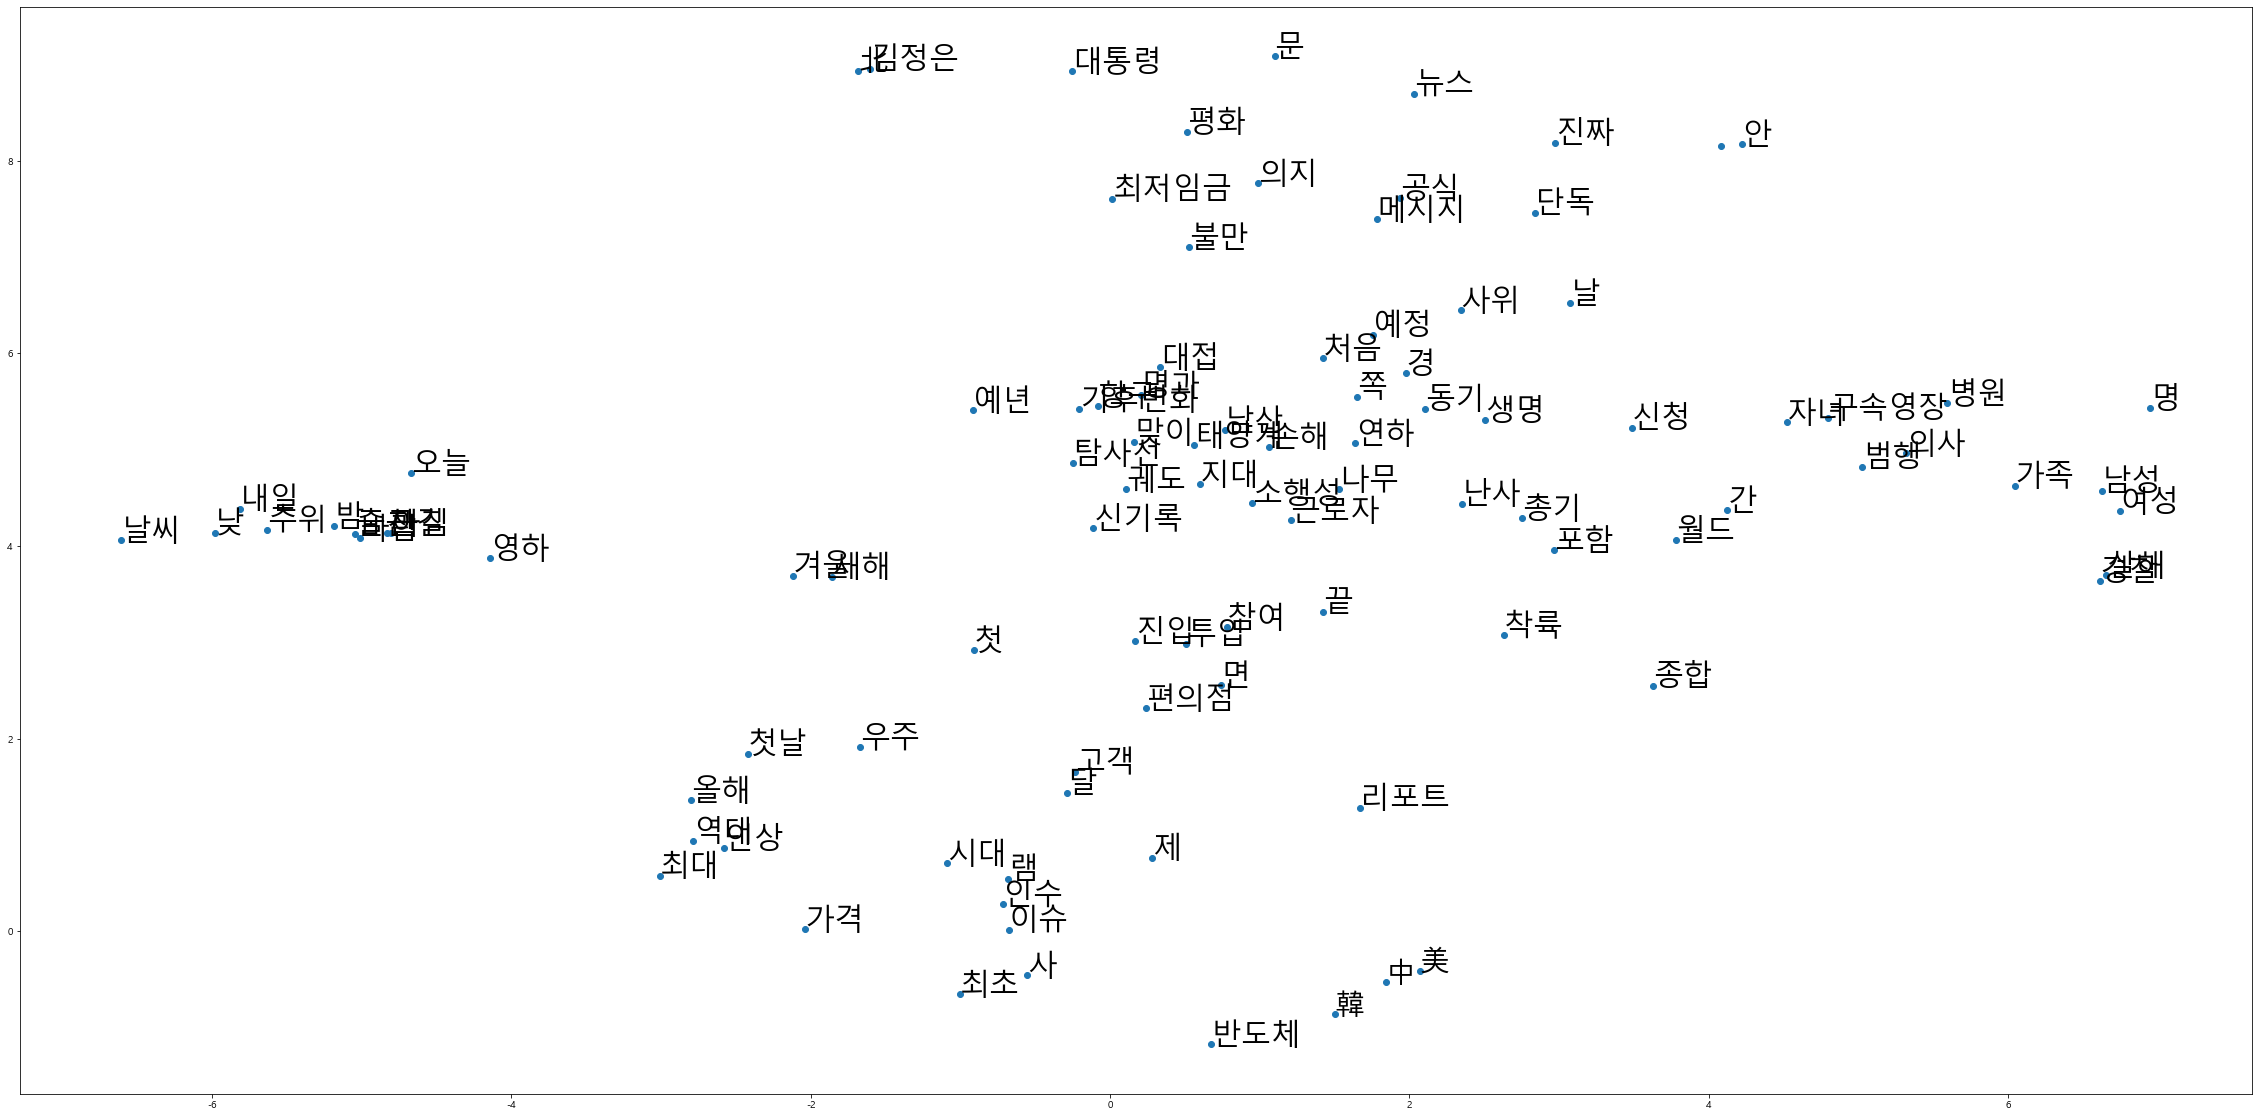

In [22]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(temp['x'], temp['y'])

for word, pos in temp.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 1),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=20000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [24]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [25]:
df['clean_title'] = df['keywords'].apply(lambda x: (' '.join(x)))

In [26]:
df['clean_title']

0         中 탐사선 경 달 면 착륙 우주경쟁 美 처음 제
1             오늘 최저임금 근로자 명 인상 역대 최대
2                     새해 최저임금 쪽 쪽 불만
3                   리포트 연하 시대 메시지 공해
4        태양계 끝 날 소행성 궤도 진입 새해 우주 신기록
                    ...             
65695        스마트폰 끼 요즘 애 노 거 고요 일 공부
65696             여신 강림 중화권 홀린 네이버웹툰
65697         인터넷 케이블 내 위약금 결합 상품 해지
65698          내년 아이폰 중국 폰 협공 폰 샌드위치
65699          쓰레기통 북극곰  기후 위기 쇼크 장면
Name: clean_title, Length: 65700, dtype: object

In [27]:
data_features = pipeline.fit_transform(df['clean_title'])
data_features

<65700x16769 sparse matrix of type '<class 'numpy.int64'>'
	with 398827 stored elements in Compressed Sparse Row format>

In [28]:
data_features.shape

(65700, 16769)

In [29]:
vocab = vectorizer.get_feature_names()
vocab[100:500]

['가로수',
 '가로수길',
 '가루',
 '가르시아',
 '가르침',
 '가마',
 '가마솥',
 '가맹',
 '가면',
 '가명',
 '가문',
 '가물',
 '가뭄',
 '가미',
 '가미카제',
 '가방',
 '가분',
 '가사',
 '가사노동',
 '가산',
 '가상',
 '가상적국',
 '가상현실',
 '가석방',
 '가성',
 '가세',
 '가속',
 '가속도',
 '가솔린',
 '가수',
 '가스',
 '가스레인지',
 '가스실',
 '가스통',
 '가슴',
 '가습기',
 '가시',
 '가식',
 '가압류',
 '가액',
 '가야',
 '가양동',
 '가업',
 '가열',
 '가오',
 '가오리',
 '가옥',
 '가와사키',
 '가요',
 '가용',
 '가운',
 '가운데',
 '가위',
 '가율',
 '가은',
 '가을',
 '가을비',
 '가의',
 '가이드',
 '가입',
 '가입자',
 '가자지구',
 '가장',
 '가재',
 '가전',
 '가점',
 '가정',
 '가정부',
 '가정폭력',
 '가족',
 '가족사',
 '가족사진',
 '가죽',
 '가중',
 '가즈',
 '가증',
 '가지',
 '가짜',
 '가처분',
 '가축화',
 '가출',
 '가치',
 '가톨릭',
 '가평',
 '가폰',
 '가해',
 '가해자',
 '가형',
 '가혹',
 '각각',
 '각계',
 '각광',
 '각국',
 '각도',
 '각막',
 '각목',
 '각방',
 '각별',
 '각본',
 '각서',
 '각성',
 '각성제',
 '각심',
 '각양각색',
 '각오',
 '각의',
 '각인',
 '각자',
 '각종',
 '각지',
 '각축',
 '각층',
 '각하',
 '간격',
 '간과',
 '간극',
 '간다',
 '간단',
 '간담',
 '간문제',
 '간밤',
 '간병',
 '간병인',
 '간부',
 '간섭',
 '간세',
 '간소화',
 '간식',
 '간암',
 '간염',
 '간의',
 '간이',
 '간장',
 '간접',
 '간주',
 '간증

In [30]:
import numpy as np
dist = np.sum(data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

keyword_counts = pd.DataFrame(dist, columns=vocab)
keyword_counts

[[ 7 26  2 ...  2  2  2]] 一筆揮之


一筆揮之  中企  中日  人事  人災  令和  克日  全大  前妻  北核  ...  히틀러  힌지  힐러리  힐링  힐스테이트  힐튼  \
0     7  26   2   5   3   2   7   2   2   3  ...    6  15    2   7      2   5   

   힘겨루기  힘자랑  힙합  勞勞  
0     2    2   2   2  

[1 rows x 16769 columns]

In [31]:
pd.DataFrame(data_features[:100].toarray(), columns=vocab).head()

一筆揮之  中企  中日  人事  人災  令和  克日  全大  前妻  北核  ...  히틀러  힌지  힐러리  힐링  힐스테이트  힐튼  \
0     0   0   0   0   0   0   0   0   0   0  ...    0   0    0   0      0   0   
1     0   0   0   0   0   0   0   0   0   0  ...    0   0    0   0      0   0   
2     0   0   0   0   0   0   0   0   0   0  ...    0   0    0   0      0   0   
3     0   0   0   0   0   0   0   0   0   0  ...    0   0    0   0      0   0   
4     0   0   0   0   0   0   0   0   0   0  ...    0   0    0   0      0   0   

   힘겨루기  힘자랑  힙합  勞勞  
0     0    0   0   0  
1     0    0   0   0  
2     0    0   0   0  
3     0    0   0   0  
4     0    0   0   0  

[5 rows x 16769 columns]

In [32]:
keyword_counts = keyword_counts.T
keyword_counts.head()

0
一筆揮之   7
中企    26
中日     2
人事     5
人災     3

In [33]:
keyword_counts.columns = ['count']
keyword_counts.head(10)

count
一筆揮之      7
中企       26
中日        2
人事        5
人災        3
令和        2
克日        7
全大        2
前妻        2
北核        3

In [34]:
keyword_counts = keyword_counts.sort_values(by='count', ascending=False)
keyword_counts = keyword_counts.reset_index()
keyword_counts.head()

index  count
0    한국   3584
1    종합   3336
2    삼성   2361
3    단독   2083
4    조국   2081

In [35]:
keyword_counts.loc[keyword_counts['index']=='엄마']

index  count
97    엄마    370

In [36]:
keyword_counts[keyword_counts['count'] >= 100]

index  count
0      한국   3584
1      종합   3336
2      삼성   2361
3      단독   2083
4      조국   2081
..    ...    ...
777    협박    100
778    도발    100
779    급감    100
780    남북    100
781  국민연금    100

[782 rows x 2 columns]

In [37]:
top_keywords = keyword_counts[:100]
top_keywords.tail()

index  count
95    북한    378
96    비판    374
97    엄마    370
98    가격    370
99    직원    368

In [38]:
len(top_keywords)

100

# Let's make network

In [39]:
import networkx as nx

### simple network practice

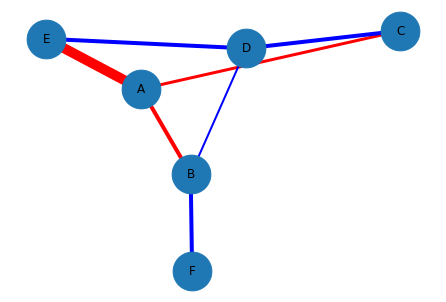

In [40]:
G = nx.Graph()
G.add_node('F', size=500)
G.add_edge('A','B', weight=4, positive=0)
G.add_edge('B', 'D', weight=2, positive=1)
G.add_edge('A', 'C', weight=3, positive=0)
G.add_edge('C', 'D', weight=4, positive=1)
G.add_edge('A', 'E', weight=10,positive=0)
G.add_edge('E', 'D', weight=4,positive=1)
G.add_edge('B', 'F', weight=4,positive=1)

colors=['red','blue']

edges = G.edges()
positive = [colors[G[u][v]['positive']] for u,v in edges]
weight = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, with_labels=True, node_size=1500, width=weight,edge_color=positive)
plt.show()

### positiveness 계산

In [41]:
def get_relate(pos, neg):
    if pos+neg != 0:
        return 50 * (pos - neg) / (pos + neg)
    else:
        return 0

df['positiveness'] = df.apply(lambda x: get_relate(x['reaction_good'], x['reaction_angry']), axis=1)
df

reaction_good  reaction_warm  reaction_sad  reaction_angry  \
0               83.0           10.0           7.0           288.0   
1             1153.0           31.0          30.0          6395.0   
2              451.0           51.0          71.0          8127.0   
3               76.0            8.0          11.0           111.0   
4              142.0           10.0           6.0            25.0   
...              ...            ...           ...             ...   
65695            8.0            1.0           0.0             7.0   
65696           43.0            2.0           1.0             5.0   
65697            5.0            0.0           0.0             1.0   
65698            3.0            2.0           0.0            26.0   
65699            3.0            0.0          37.0             3.0   

       reaction_next  comment    male  female  age_10  age_20  ...  \
0               10.0    701.0   638.0    63.0    21.0    63.0  ...   
1               59.0   5687.0  4493.0  1194.0    57.0   569.0  ...   
2              125.0   8249.0  6434.0  1815.0   165.0  1402.0  ...   
3               32.0    242.0   169.0    73.0     2.0    41.0  ...   
4               21.0    150.0   126.0    24.0     8.0    16.0  ...   
...              ...      ...     ...     ...     ...     ...  ...   
65695            1.0     23.0    -1.0    -1.0    -1.0    -1.0  ...   
65696            1.0     25.0    -1.0    -1.0    -1.0    -1.0  ...   
65697            1.0      8.0    -1.0    -1.0    -1.0    -1.0  ...   
65698            1.0     29.0    -1.0    -1.0    -1.0    -1.0  ...   
65699            7.0     35.0    -1.0    -1.0    -1.0    -1.0  ...   

                                                    href   press  section  \
0      https://news.naver.com/main/ranking/read.nhn?r...    동아일보      104   
1      https://news.naver.com/main/ranking/read.nhn?r...     뉴스1      102   
2      https://news.naver.com/main/ranking/read.nhn?r...    JTBC      101   
3      https://news.naver.com/main/ranking/read.nhn?r...     SBS      103   
4      https://news.naver.com/main/ranking/read.nhn?r...    연합뉴스      105   
...                                                  ...     ...      ...   
65695  https://news.naver.com/main/ranking/read.nhn?r...  파이낸셜뉴스      105   
65696  https://news.naver.com/main/ranking/read.nhn?r...    한국경제      105   
65697  https://news.naver.com/main/ranking/read.nhn?r...  디지털데일리      105   
65698  https://news.naver.com/main/ranking/read.nhn?r...    한국경제      105   
65699  https://news.naver.com/main/ranking/read.nhn?r...     한겨레      105   

        views  year month day                               keywords  \
0      170309  2019     1   1  [中, 탐사선, 경, 달, 면, 착륙, 우주경쟁, 美, 처음, 제]   
1      637054  2019     1   1         [오늘, 최저임금, 근로자, 명, 인상, 역대, 최대]   
2      758151  2019     1   1                   [새해, 최저임금, 쪽, 쪽, 불만]   
3      308662  2019     1   1                 [리포트, 연하, 시대, 메시지, 공해]   
4       76153  2019     1   1  [태양계, 끝, 날, 소행성, 궤도, 진입, 새해, 우주, 신기록]   
...       ...   ...   ...  ..                                    ...   
65695   10971  2019    12  31      [스마트폰, 끼, 요즘, 애, 노, 거, 고요, 일, 공부]   
65696   10568  2019    12  31               [여신, 강림, 중화권, 홀린, 네이버웹툰]   
65697   10295  2019    12  31         [인터넷, 케이블, 내, 위약금, 결합, 상품, 해지]   
65698    9559  2019    12  31          [내년, 아이폰, 중국, 폰, 협공, 폰, 샌드위치]   
65699    9229  2019    12  31          [쓰레기통, 북극곰, , 기후, 위기, 쇼크, 장면]   

                       clean_title  positiveness  
0       中 탐사선 경 달 면 착륙 우주경쟁 美 처음 제    -27.628032  
1           오늘 최저임금 근로자 명 인상 역대 최대    -34.724430  
2                   새해 최저임금 쪽 쪽 불만    -44.742364  
3                 리포트 연하 시대 메시지 공해     -9.358289  
4      태양계 끝 날 소행성 궤도 진입 새해 우주 신기록     35.029940  
...                            ...           ...  
65695      스마트폰 끼 요즘 애 노 거 고요 일 공부      3.333333  
65696           여신 강림 중화권 홀린 네이버웹툰     39.583333  
65697       인터넷 케이블 내 위약금 결합 상품 해지     33.333333  
65698        내년 아이폰 중국 폰 협공 폰 샌드위치   

## Keyword 출현 빈도 co-occurence matrix 만들기

In [42]:
keyword_cooc_matrix = pd.DataFrame(columns = top_keywords['index'], index = top_keywords['index'])
keyword_cooc_matrix[:] = int(0)
keyword_cooc_matrix.head()

index  한국  종합  삼성  단독  조국  대통령  일본  트럼프  논란  속보  ...  베트남  문제  혐의  추락  하나  북한  \
index                                            ...                            
한국      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
종합      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
삼성      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
단독      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
조국      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   

index  비판  엄마  가격  직원  
index                  
한국      0   0   0   0  
종합      0   0   0   0  
삼성      0   0   0   0  
단독      0   0   0   0  
조국      0   0   0   0  

[5 rows x 100 columns]

In [43]:
key_list = list(top_keywords['index'])
for title_key in df['keywords']:
    for keyword1 in title_key:
        for keyword2 in title_key:
            if keyword1 in key_list and keyword2 in key_list:
                keyword_cooc_matrix[keyword1][keyword2] += 1

In [44]:
keyword_cooc_matrix

index    한국    종합    삼성    단독    조국  대통령   일본  트럼프   논란   속보  ...  베트남  문제  \
index                                                         ...            
한국     3714   199    40   104    98  127  355   92  117  108  ...   29  25   
종합      199  3340    96    12    70  180   42  194   65    3  ...   35  19   
삼성       40    96  2447   122     0    6   75   44   36   18  ...   18  24   
단독      104    12   122  2095   201   27   39   12   48    1  ...    9  10   
조국       98    70     0   201  2265  116    6    0   90  120  ...    0  33   
...     ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...  ...  ..   
북한       23    19     0    12     0   15   24   47    5   39  ...    1   6   
비판       45    34     0     5    44   45   20   16   19    5  ...    0   3   
엄마        8     8     0     8     7    3    0    0    9    1  ...    2   1   
가격       13    13    14     5     0    3    8    0    4    1  ...    0   5   
직원       17    13     8    23    11    1    6    1   14    6  ...    0   3   

index  혐의  추락  하나   북한   비판   엄마   가격   직원  
index                                       
한국      3   9  17   23   45    8   13   17  
종합     43  37   8   19   34    8   13   13  
삼성      2   5  21    0    0    0   14    8  
단독     15   4   4   12    5    8    5   23  
조국     32   1  17    0   44    7    0   11  
...    ..  ..  ..  ...  ...  ...  ...  ...  
북한      2   1   0  382    1    0    0    0  
비판      0   0   3    1  374    1    0    1  
엄마      0   0   3    0    1  394    0    0  
가격      0   0   1    0    0    0  390    0  
직원      7   2   1    0    1    0    0  370  

[100 rows x 100 columns]

In [45]:
edge_list = []
for index, row in keyword_cooc_matrix.iterrows():
    i = 0
    for col in row:
        weight = col
        edge_list.append((index, keyword_cooc_matrix.columns[i], weight))
        i += 1
len(edge_list)

10000

In [46]:
update_edge_list = [edge for edge in edge_list if not edge[2] == 0.0]
len(update_edge_list)

7220

In [47]:
for edge in update_edge_list:
    if edge[0] == edge[1]:
        update_edge_list.remove(edge)
len(update_edge_list)

7120

## positiveness에 대해 co-occurence matrix 만들기

In [48]:
positive_cooc_matrix = pd.DataFrame(columns = top_keywords['index'], index = top_keywords['index'])
positive_cooc_matrix[:] = int(0)
positive_cooc_matrix.head()

index  한국  종합  삼성  단독  조국  대통령  일본  트럼프  논란  속보  ...  베트남  문제  혐의  추락  하나  북한  \
index                                            ...                            
한국      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
종합      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
삼성      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
단독      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   
조국      0   0   0   0   0    0   0    0   0   0  ...    0   0   0   0   0   0   

index  비판  엄마  가격  직원  
index                  
한국      0   0   0   0  
종합      0   0   0   0  
삼성      0   0   0   0  
단독      0   0   0   0  
조국      0   0   0   0  

[5 rows x 100 columns]

In [49]:
key_list = list(top_keywords['index'])
for title_key, pos in zip(df['keywords'], df['positiveness']):
    set(title_key)
    for keyword1 in title_key:
        for keyword2 in title_key:
            if keyword1 in key_list and keyword2 in key_list:
                positive_cooc_matrix[keyword1][keyword2] += pos

In [50]:
positive_cooc_matrix

index     한국     종합     삼성     단독     조국   대통령    일본   트럼프    논란    속보  ...  \
index                                                                   ...   
한국    -40185  -1783   -565  -1502    403 -1612 -3883  -874 -2896  -886  ...   
종합     -1783 -53601    280   -159  -1224 -3409   305  2148 -1996   -61  ...   
삼성      -565    280  27080   1001      0  -170  1326  -980  -440   180  ...   
단독     -1502   -159   1001 -48464  -5379  -649  -132  -239 -1798   -48  ...   
조국       403  -1224      0  -5379 -37752 -2587  -186     0 -2605 -2033  ...   
...      ...    ...    ...    ...    ...   ...   ...   ...   ...   ...  ...   
북한      -272   -546      0   -311      0  -173  -229   -99  -245  -807  ...   
비판      -537   -701      0    -43   -466  -974   -82   -50  -680  -176  ...   
엄마      -376   -377      0   -362   -247   -28     0     0  -129   -48  ...   
가격       -38   -437    161      5      0  -125    59     0  -142   -45  ...   
직원      -107   -470     74   -695   -411   -17  -257    34  -452  -261  ...   

index  베트남    문제    혐의    추락   하나    북한    비판    엄마    가격    직원  
index                                                            
한국    -931  -468   -48  -339  173  -272  -537  -376   -38  -107  
종합    -288  -519 -1524 -1070 -218  -546  -701  -377  -437  -470  
삼성     -69  -433   -75  -166 -119     0     0     0   161    74  
단독    -264  -430  -313  -181   -6  -311   -43  -362     5  -695  
조국       0 -1006   561    48  -84     0  -466  -247     0  -411  
...    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...  
북한      41   142    18   -44    0 -7003    27     0     0     0  
비판       0   -68     0     0  -50    27 -6514   -41     0   -49  
엄마     -83   -41     0     0  -74     0   -41 -7585     0     0  
가격       0    51     0     0  -15     0     0     0 -4970     0  
직원       0  -105  -331   -13   41     0   -49     0     0 -9064  

[100 rows x 100 columns]

## Text Network Visualization

In [51]:
keyword_G = nx.Graph()
for keyword in top_keywords['index']:
    keyword_G.add_node(keyword)
    
keyword_G.add_weighted_edges_from(update_edge_list)

# check data
# keyword_G.nodes(data=True)
# keyword_G.edges(data=True)

### 빈도수에 따른 edge width

In [52]:
node_scalar = 100
edge_scalar = 80
node_sizes = top_keywords['count'] * 2
widths = []
edges = nx.get_edge_attributes(keyword_G, 'weight')
for key in edges.keys():
    widths.append(float(edges[key])/edge_scalar)

### positiveness filtering

In [53]:
pos_list = []
for index, row in positive_cooc_matrix.iterrows():
    i = 0
    for col in row:
        positiveness = col
        pos_list.append([(index, positive_cooc_matrix.columns[i]), positiveness])
        i += 1
len(pos_list)

10000

In [54]:
update_pos_list = []
for item in pos_list:
    key = item[0]
    positive = item[1]
    if positive < -100:
        positive = 0
    elif positive in range(-100,100):
        positive = 1
    else:
        positive = 2
    if key in edges.keys():
        update_pos_list.append(positive)
len(update_pos_list)

3560

In [55]:
color = ['blue', 'black', 'red']
edge_colors = [color[x] for x in update_pos_list]

## 그래프 그리기


## Node 
>+ label은 기사제목의 keyword를 나타낸다.
>+ node의 크기가 클수록 뉴스 기사 제목에 많이 사용된 keyword
## Edge
>- 각 edge의 color는 두 keyword가 함께 나타났을 때 독자들의 반응을 나타낸다
>> - 빨간색은 긍정적인 반응
>> - 검은색은 중립적인 반응
>> - 파란색은 부정적인 반응
>- edge의 두께가 두꺼울수록 두 keyword가 함께 나타난 기사의 수가 많음을 의미한다.

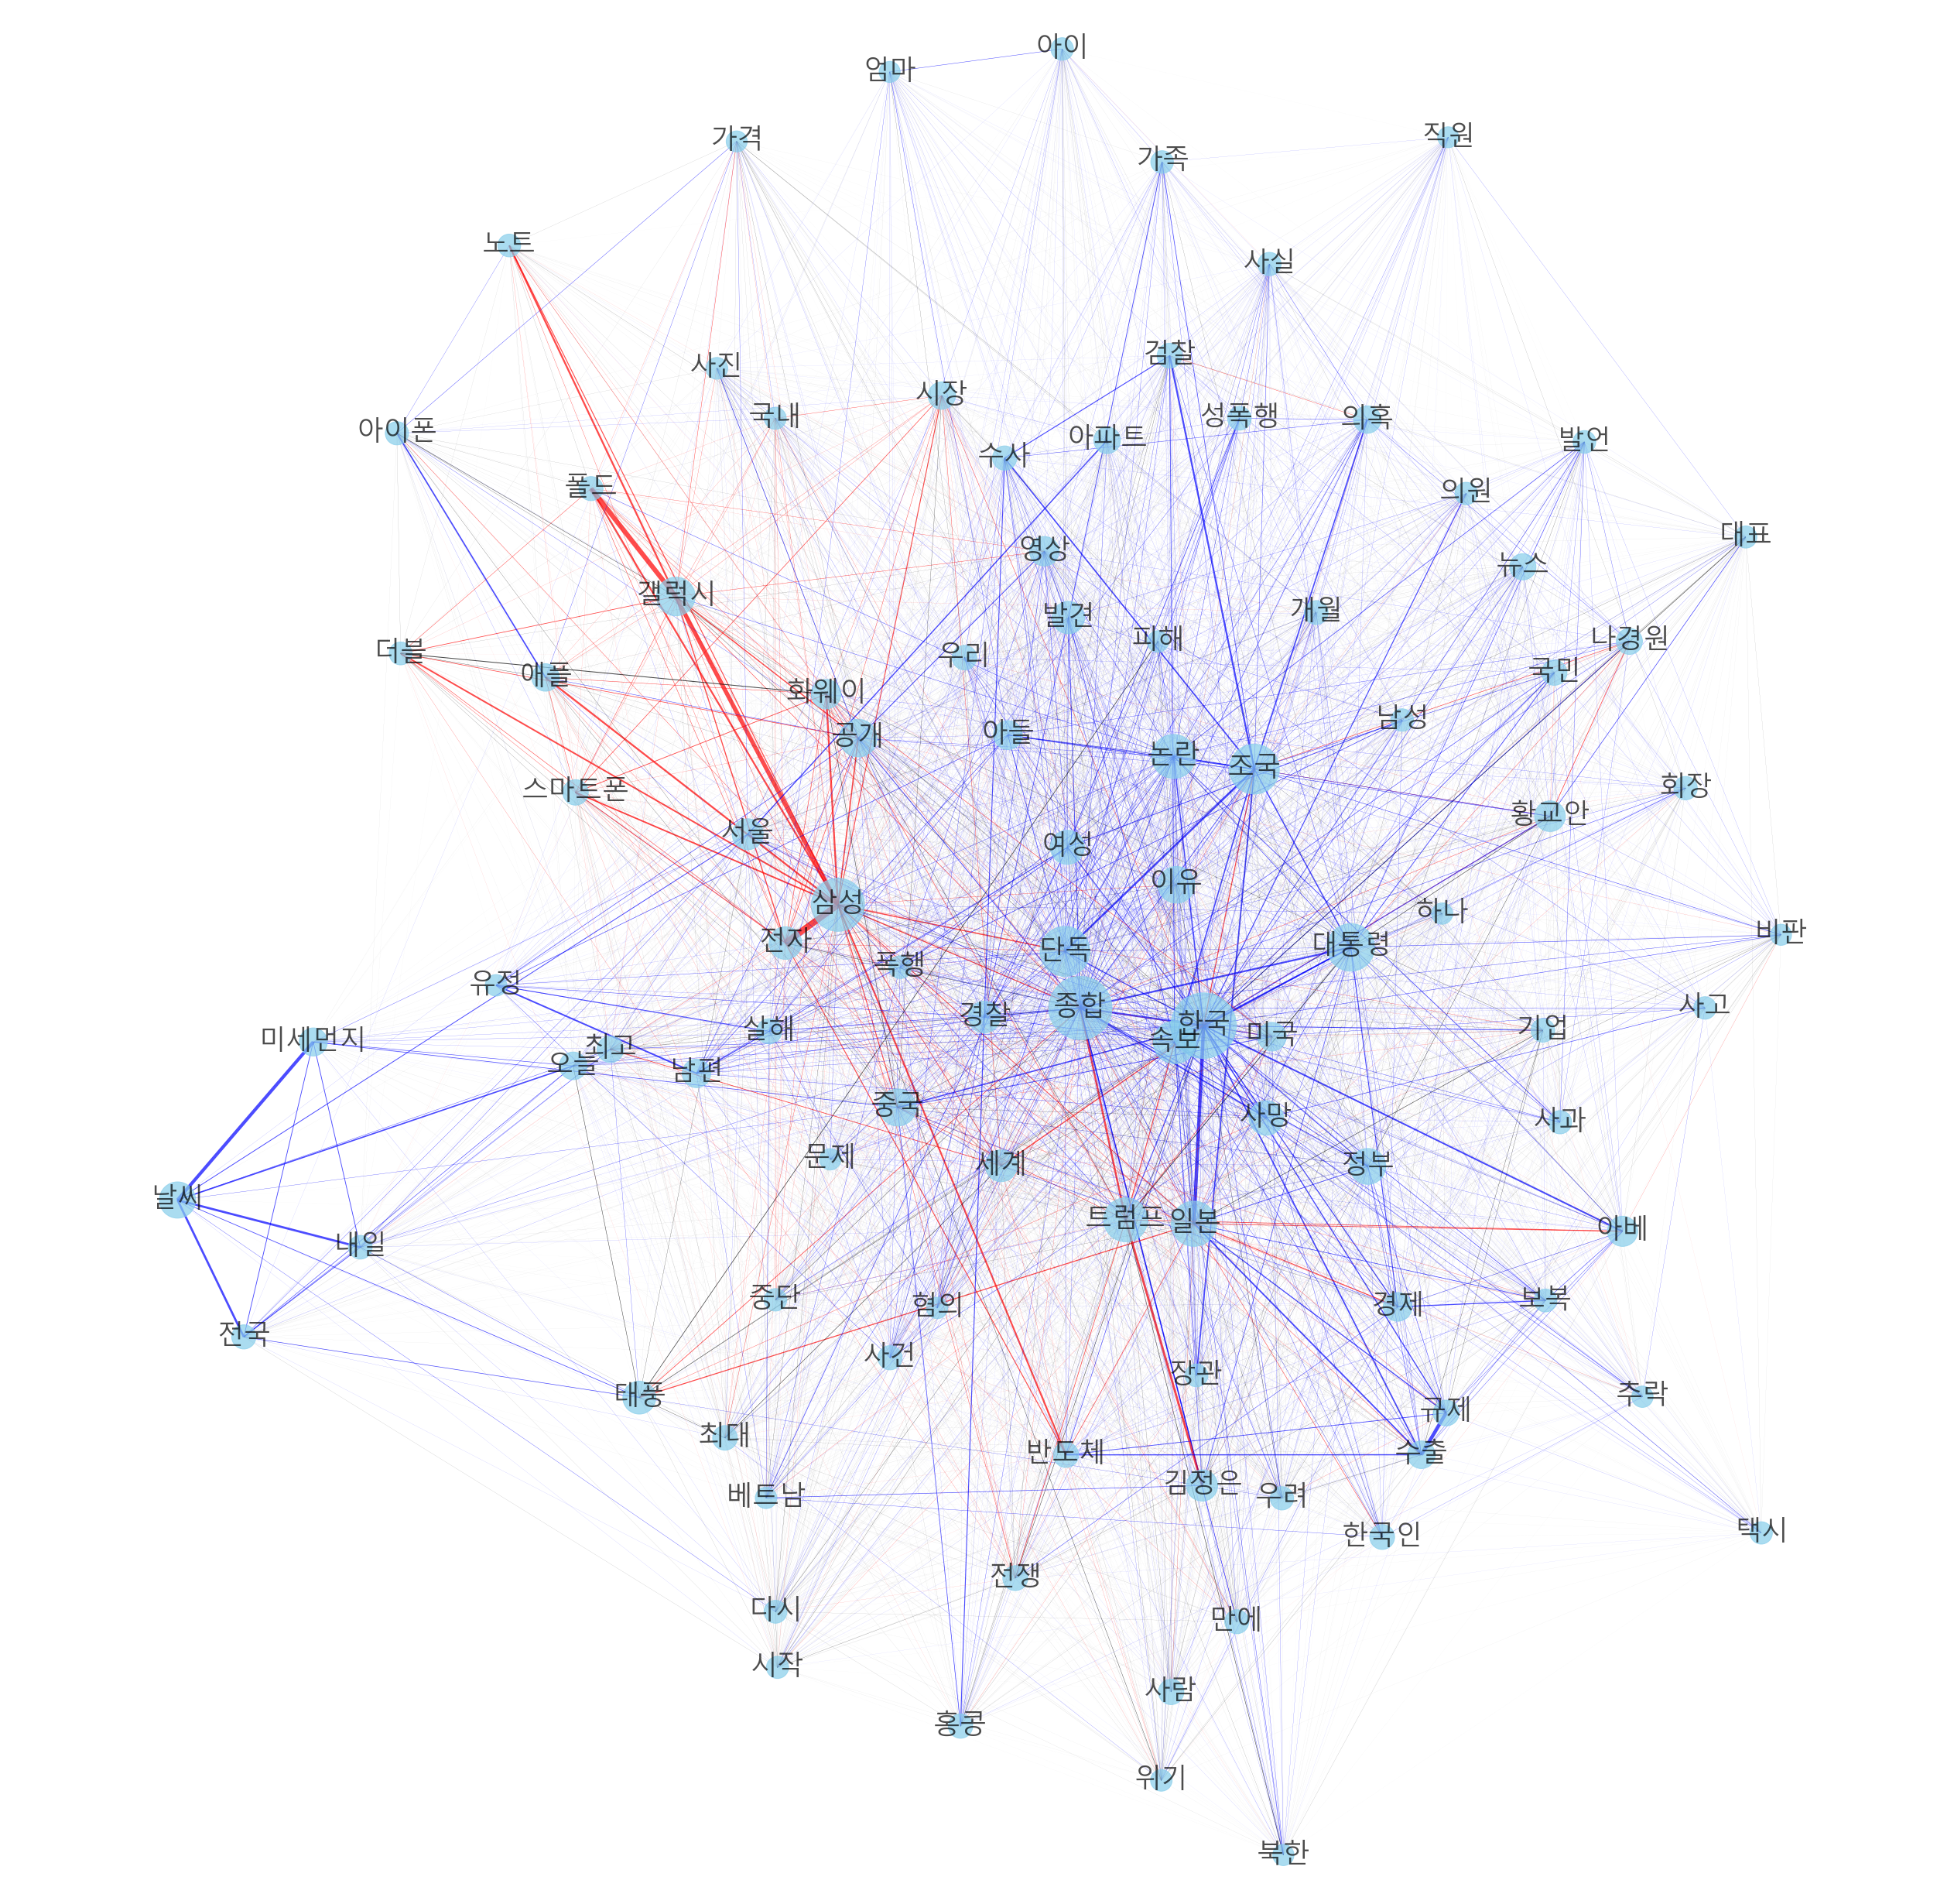

In [56]:
plt.figure(figsize=(45, 45))
plt.margins(x=0.1, y=0.02)
pos = nx.spring_layout(keyword_G, k=0.3, iterations=20)
nx.draw(keyword_G,pos, with_labels=True, font_size = 35, font_family='Malgun Gothic', node_size=node_sizes,
       width = widths, alpha=0.7, node_color = 'skyblue', edge_color = edge_colors)

In [57]:
def pos_value(positiveness):
    if positiveness in range(-5, 5):
        return 0
    elif positiveness < -5:
        return -1
    else:
        return 1

df['positive_value'] = df['positiveness'].apply(lambda x: pos_value(x))
df.loc[df['positiveness'].isna()]

reaction_good  reaction_warm  reaction_sad  reaction_angry  \
63360            NaN            NaN           NaN             NaN   
63390            NaN            NaN           NaN             NaN   

       reaction_next  comment  male  female  age_10  age_20  ...     press  \
63360            NaN      NaN   NaN     NaN     NaN     NaN  ...  뉴스위크 한국판   
63390            NaN      NaN   NaN     NaN     NaN     NaN  ...  뉴스위크 한국판   

       section   views  year month day            keywords    clean_title  \
63360      105   91630  2019    10  15  [당신, 사이, 휴대전화, 충전]  당신 사이 휴대전화 충전   
63390      105  101706  2019    10  16  [당신, 사이, 휴대전화, 충전]  당신 사이 휴대전화 충전   

       positiveness  positive_value  
63360           NaN               1  
63390           NaN               1  

[2 rows x 26 columns]

## 뉴스 keywords로 positiveness를 예측해보자

##### train set과 test set분리

In [58]:
shuffle_df = df.dropna().sample(frac=1)
train = shuffle_df[:50000]
test = shuffle_df[50000:]
train.shape, test.shape

((50000, 26), (15698, 26))

In [113]:
# 키워드가 없는 학슴데이터 제거
count = 0
for idx ,keywords in train['keywords'].items():
    if len(keywords) == 0:
        print(idx)
        print(count)
        train = train.drop(idx)
    count+=1

In [112]:
train.shape

(49998, 26)

##### train data로 Word2Vec 학습

In [115]:
model = Word2Vec(train['keywords'], size=200, window=10, min_count=5, workers=4, sg=1, negative=5,sample = 1e-2)

In [72]:
def makeFeatureVec(keywords, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for keyword in keywords:
        if keyword in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[keyword])
    # 
    # Divide the result by the number of words to get the average
    if nwords != 0:
        featureVec = np.divide(featureVec,nwords)
    return featureVec

In [73]:
def getAvgFeatureVecs(keywords_list, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0.
    # 
    # Preallocate a 2D numpy array, for speed
    keywordFeatureVecs = np.zeros((len(keywords_list),num_features),dtype="float32")
    # Loop through the reviews
    for keywords in keywords_list:
       # Print a status message every 1000th review
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(keywords_list)))
       # 
       # Call the function (defined above) that makes average feature vectors
       keywordFeatureVecs[int(counter)] = makeFeatureVec(keywords, model, num_features)
       #
       # Increment the counter
       counter = counter + 1.
    return keywordFeatureVecs

In [99]:
train.loc[24645]

reaction_good                                                    10
reaction_warm                                                     2
reaction_sad                                                      1
reaction_angry                                                  109
reaction_next                                                     2
comment                                                         314
male                                                            261
female                                                           53
age_10                                                           16
age_20                                                          141
age_30                                                          100
age_40                                                           41
age_50                                                            9
age_60                                                            6
title                                           

In [117]:
num_features=200
print ("Creating average feature vecs for train data")
trainDataVecs = getAvgFeatureVecs(list(train['keywords']), model, num_features )

print ("Creating average feature vecs for test data")
testDataVecs = getAvgFeatureVecs(list(test['keywords']), model, num_features )

Creating average feature vecs for train data
Review 0 of 49998
Review 1000 of 49998
Review 2000 of 49998
Review 3000 of 49998
Review 4000 of 49998
Review 5000 of 49998
Review 6000 of 49998
Review 7000 of 49998
Review 8000 of 49998
Review 9000 of 49998
Review 10000 of 49998
Review 11000 of 49998
Review 12000 of 49998
Review 13000 of 49998
Review 14000 of 49998
Review 15000 of 49998
Review 16000 of 49998
Review 17000 of 49998
Review 18000 of 49998
Review 19000 of 49998
Review 20000 of 49998
Review 21000 of 49998
Review 22000 of 49998
Review 23000 of 49998
Review 24000 of 49998
Review 25000 of 49998
Review 26000 of 49998
Review 27000 of 49998
Review 28000 of 49998
Review 29000 of 49998
Review 30000 of 49998
Review 31000 of 49998
Review 32000 of 49998
Review 33000 of 49998
Review 34000 of 49998
Review 35000 of 49998
Review 36000 of 49998
Review 37000 of 49998
Review 38000 of 49998
Review 39000 of 49998
Review 40000 of 49998
Review 41000 of 49998
Review 42000 of 49998
Review 43000 of 49998


In [64]:
trainDataVecs

array([[ 0.00043041,  0.01442069, -0.00958726, ...,  0.01179216,
        -0.0162942 , -0.02673106],
       [ 0.01943302,  0.06735269, -0.05372863, ..., -0.06552052,
        -0.02268501, -0.23924598],
       [-0.00050766, -0.02403509, -0.00978308, ...,  0.16409539,
        -0.19397132,  0.12413268],
       ...,
       [ 0.02204702, -0.02633801,  0.01103393, ...,  0.17500553,
        -0.11914758,  0.20271169],
       [ 0.05500729,  0.02657947, -0.04553394, ..., -0.23524514,
        -0.13298069, -0.39496288],
       [-0.02457257, -0.04278373,  0.08312931, ...,  0.12012064,
        -0.17919026,  0.14864554]], dtype=float32)

### RandomForest로 학습시키기

In [118]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, random_state = 2020, n_jobs=-1)

In [119]:
forest = forest.fit(trainDataVecs, train['positive_value'])

In [127]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(5, shuffle=True, random_state=0)
score = cross_val_score(forest, trainDataVecs, train['positive_value'], cv=cv, scoring='accuracy')
score

array([0.7541    , 0.7515    , 0.7499    , 0.75267527, 0.74807481])

In [128]:
result = forest.predict( testDataVecs )

In [130]:
from sklearn.metrics import accuracy_score

accuracy_score(test['positive_value'], result)

0.7562746846732068